In [29]:
import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import os
import pandas as pd
from sqlalchemy import create_engine
import pyodbc
from datetime import datetime
import re
import urllib
import db_config

In [2]:
def log_progress(message):
    
    with open('./logs/logs.txt', 'a') as f:
        f.write(f'{datetime.now()}: {message}\n')

### BangGood Pipeline

In [3]:
###LOAD DATA TO CSV
def load_to_csv(data, file_name):
    file_name = f'data/{file_name}'
    df = pd.DataFrame(data)
    if os.path.exists(file_name):
        # If CSV exists, append new data without writing headers
        df.to_csv(file_name, mode='a', index=False, header=False)
    else:
        # If CSV does not exist, create it and write headers
        df.to_csv(file_name, mode='w', index=False, header=True)
    log_progress(f'Loading: Loading data into {file_name}')
    

raw_data = []
clean_data = []

category_list = [
    'https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=',
    'https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=',
    'https://www.banggood.com/Wholesale-RC-Airplane-ca-7005.html?cat_id=7005&page=',
    'https://www.banggood.com/Wholesale-FPV-Racing-Drone-ca-7006.html?cat_id=7006&page=',
    'https://www.banggood.com/Wholesale-RC-Car-ca-7008.html?cat_id=7008&page='
]


def extract_data():

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(options=chrome_options)

    log_progress(f'DATA EXTRACTION STARTED')
    
    for base_url in category_list:
        for page in range(1, 6):
            url = f"{base_url}{page}"
            print(f"Scraping: {url}")

            driver.get(url)

            # Wait until at least one product appears
            try:
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "ul.goodlist li"))
                )
            except:
                print("Products did not load on this page.")
                continue

            # -----------------------------
            # Lazy loading: scroll to bottom
            # -----------------------------
            SCROLL_PAUSE_TIME = 1.5
            last_height = driver.execute_script("return document.body.scrollHeight")

            while True:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(SCROLL_PAUSE_TIME)
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:
                    break
                last_height = new_height

            # Parse page
            soup = BeautifulSoup(driver.page_source, "html.parser")

            
            category_tag = soup.select_one(".breadcrumb ul li:last-of-type")
            product_category = category_tag.get_text(strip=True) if category_tag else ""            
            all_listings = soup.select("ul.goodlist li")

            if not all_listings:
                print("No listings found on this page.")
                continue

            # Extract data
            for product in all_listings:

                title_tag = product.find("a", class_="title")
                price_tag = product.find("span", class_="price")
                rating_tag = product.find("span", class_="review-text")
                review_tag = product.find("a", class_="review")

                product_name = title_tag.get_text(strip=True) if title_tag else ""
                product_url = title_tag.get("href") if title_tag else ""
                product_price = price_tag.get_text(strip=True) if price_tag else ""
                product_rating = rating_tag.get_text(strip=True) if rating_tag else ""
                product_review = review_tag.get_text(strip=True) if review_tag else ""

                raw_data.append({
                    "Title": product_name,
                    "Price": product_price,
                    "Rating": product_rating,
                    "Reviews": product_review,
                    "Category": product_category,
                    "URL": product_url
                })
    
    log_progress(f'DATA EXTRACTION ENDED')

    load_to_csv(raw_data, 'banggood_listings_raw.csv')
    driver.quit()


extract_data()

Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=1
Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=2
Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=3
Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=4
Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=5
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=1
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=2
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=3
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=4
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=5
Scraping: https://www.banggood.com/Wholesale-RC-Airplane-ca-7005.html?cat_id=7005&pag

## Cleaning Data

In [4]:
def cleaning_data(raw_data):
    
    log_progress(f'DATA CLEANING: STARTED')
    for product in raw_data:
        
        price = product.get('Price')
        if price is not None and str(price).strip() != "":
            product['Price'] = float(str(price).replace("US$", "").replace(",", "").strip())
        else:
            product['Price'] = None
        
        reviews = product.get('Reviews')
        if reviews is not None and str(reviews).strip() != "":
            product['Reviews'] = str(reviews).split()[0]
        else:
            product['Reviews'] = None
        
        rating = product.get('Rating')
        if rating is None or str(rating).strip() == "":
            product['Rating'] = None
            
        category = product.get('Category')
        if category is None or str(category).strip() == "":
            product['Category'] = None
        
        url = product.get('URL')
        if url is None or str(url).strip() == "":
            product['URL'] = None
        
        title = product.get('Title')    
        if title is None or str(title).strip() == "":
            product['Title'] = None
        
        
    log_progress(f'DATA CLEANING: ENDED') 
    load_to_csv(raw_data, 'banggood_listings_clean.csv')
    

cleaning_data(raw_data)

## Part 3: Python Exploratory Analysis

In [ ]:
import matplotlib.pyplot as plt

In [8]:
df = pd.DataFrame(raw_data)

##### 1- Price distribution per category

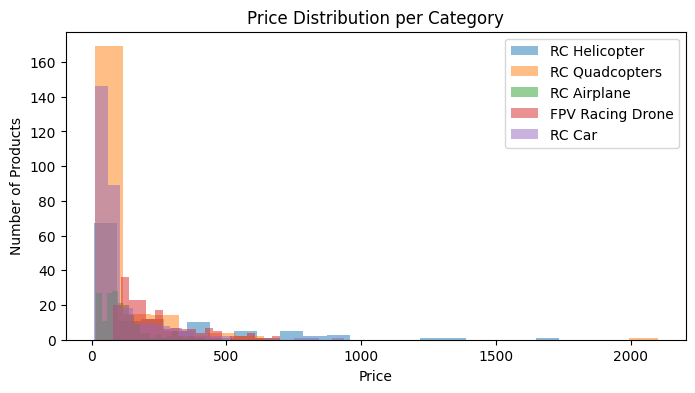

In [13]:
plt.figure(figsize=(8, 4))
bins = 20  # number of bins for all categories

# Get unique categories
categories = df['Category'].dropna().unique()

for cat in categories:
    subset = df[df['Category'] == cat]['Price'].dropna()
    plt.hist(subset, bins=bins, alpha=0.5, label=cat)

plt.title('Price Distribution per Category')
plt.xlabel('Price')
plt.ylabel('Number of Products')
plt.legend()
plt.show()

##### 2- - Rating vs Price correlation

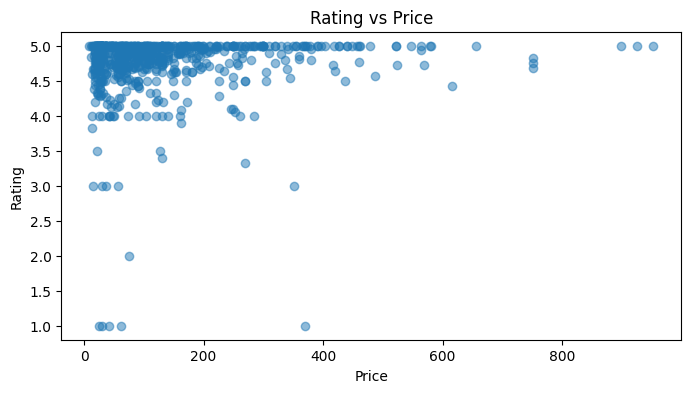

In [15]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Drop missing values
df_corr = df.dropna(subset=['Price', 'Rating'])

plt.figure(figsize=(8, 4))
plt.scatter(df_corr['Price'], df_corr['Rating'], alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Rating')
plt.title('Rating vs Price')
plt.show()

##### 3- - Top reviewed products

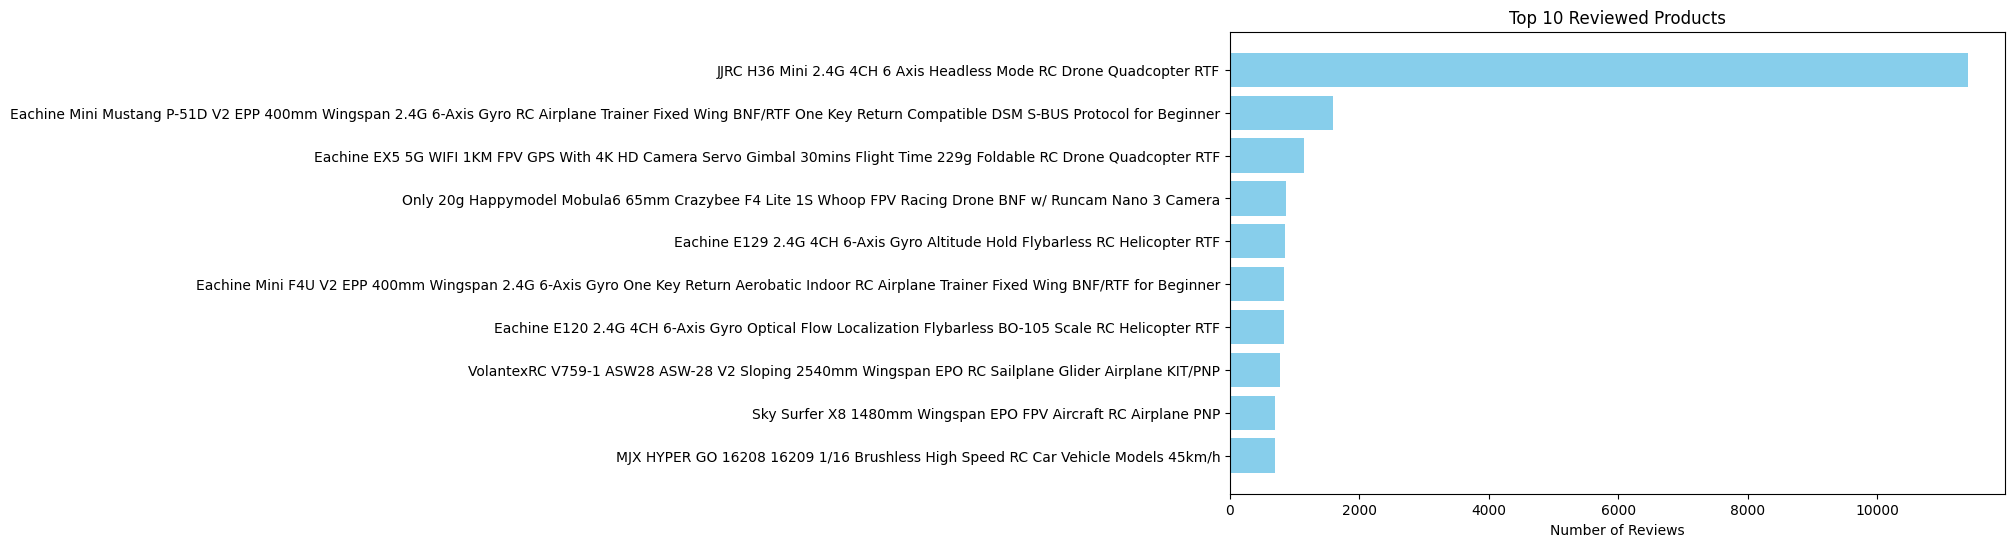

In [16]:
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df_top = df.dropna(subset=['Reviews'])

# Sort by Reviews descending
df_top = df_top.sort_values(by='Reviews', ascending=False)

# Pick top 10
top_10_reviewed = df_top.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_reviewed['Title'], top_10_reviewed['Reviews'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.title('Top 10 Reviewed Products')
plt.gca().invert_yaxis()  # highest on top
plt.show()

##### 4- Best value metric per category


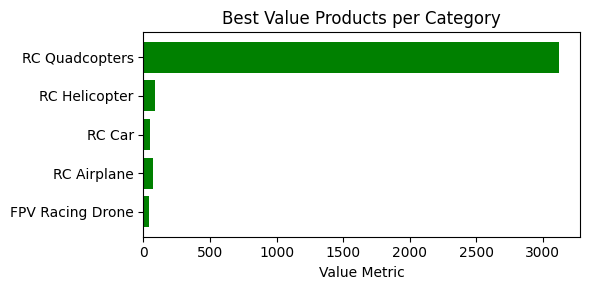

In [19]:
# --- 1️⃣ Ensure numeric columns ---
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# --- 2️⃣ Drop rows with missing essential data ---
df_clean = df.dropna(subset=['Price', 'Rating', 'Reviews']).copy()

# --- 3️⃣ Compute Best Value metric ---
# Value = (Rating * Reviews) / Price
df_clean.loc[:, 'Value'] = (df_clean['Rating'] * df_clean['Reviews']) / df_clean['Price']

# --- 4️⃣ Find top value product per category ---
top_value_per_category = df_clean.loc[df_clean.groupby('Category')['Value'].idxmax()]

# --- 5️⃣ Display top value products ---

# --- 6️⃣ Optional: Plot Best Value per Category ---
plt.figure(figsize=(6, 3))
plt.barh(top_value_per_category['Category'], top_value_per_category['Value'], color='green')
plt.xlabel('Value Metric')
plt.title('Best Value Products per Category')
plt.tight_layout()
plt.show()

## Load DATA to Database

In [32]:
###LOAD DATA TO DATABASE
 # --- Configuration ---
server = db_config.DB_SERVER       # SQL Server name or IP
database = db_config.DB_NAME   # target database
username = db_config.DB_USER
password = db_config.DB_PASSWORD
table_name = db_config.DB_TABLE_NAME
csv_file = "data/banggood_listings_clean.csv"
engine = create_engine(f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")

def load_to_database():
    

    # --- Step 1: Connect to master DB to check/create database ---
    conn_str_master = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE=master;UID={username};PWD={password}"
    conn = pyodbc.connect(conn_str_master, autocommit=True)
    cursor = conn.cursor()

    # Check if database exists
    cursor.execute(f"SELECT database_id FROM sys.databases WHERE Name = '{database}'")
    db_exists = cursor.fetchone()

    if not db_exists:
        cursor.execute(f"CREATE DATABASE {database}")
        print(f"Database '{database}' created.")
    else:
        print(f"Database '{database}' already exists.")

    cursor.close()
    conn.close()

    # --- Step 2: Load CSV into pandas DataFrame ---
    df = pd.read_csv(csv_file)

    # --- Step 3: Connect to the target database using SQLAlchemy ---
    log_progress(f'Connecting: Connecting to database') 
    

    # --- Step 4: Dump data to table ---
    # 'if_exists=append' will add new rows if table exists, otherwise it creates a new table
    df.to_sql(table_name, con=engine, if_exists='append', index=False)
    log_progress(f'Dumping: Dumping data into database')
    
load_to_database()


Database 'BangDoodDB' already exists.


### Part 5: SQL Aggregated Analysis (Minimum 5 Queries)

In [35]:
def runDbQuery(query):
    result = pd.read_sql_query(query, engine)
    return result

##### Query 1: Average price per category

In [40]:
query_1 = runDbQuery(f" SELECT Category, ROUND(AVG(Price), 2) AS AveragePricePerCategory FROM {table_name} GROUP BY Category ORDER BY AveragePricePerCategory DESC;")
query_1

,Category,AveragePricePerCategory
0,FPV Racing Drone,237.92
1,RC Helicopter,231.49
2,RC Airplane,114.89
3,RC Quadcopters,96.79
4,RC Car,96.39


##### Query 2: Average rating per category

In [41]:
query_2 = runDbQuery(f" SELECT Category, ROUND(AVG(Rating), 2) AS AverageRatingPerCategory FROM {table_name} GROUP BY Category ORDER BY AverageRatingPerCategory DESC;")
query_2

,Category,AverageRatingPerCategory
0,RC Airplane,4.84
1,RC Helicopter,4.79
2,FPV Racing Drone,4.78
3,RC Car,4.72
4,RC Quadcopters,4.66


##### Query 3: - Product count per category

In [42]:
query_3 = runDbQuery(f" SELECT Category, COUNT(*) AS CountPerCategory FROM {table_name} GROUP BY Category ORDER BY CountPerCategory DESC;")
query_3

,Category,CountPerCategory
0,RC Car,300
1,RC Quadcopters,208
2,FPV Racing Drone,185
3,RC Airplane,185
4,RC Helicopter,127


##### Query 4: - Top 5 reviewed items per category

In [43]:
query_4 = runDbQuery(f"SELECT * FROM {table_name} AS t1 WHERE Reviews IN (SELECT TOP 5 Reviews FROM {table_name} AS t2 WHERE t2.Category = t1.Category ORDER BY Reviews DESC) ORDER BY Category, Reviews DESC;")
query_4

,Title,Price,Rating,Reviews,Category,URL
0,Only 20g Happymodel Mobula6 65mm Crazybee F4 L...,108.09,4.90,865.0,FPV Racing Drone,https://www.banggood.com/Only-20g-Happymodel-M...
1,Emax Tinyhawk II Freestyle 2.5 Inch FPV Racing...,125.99,4.90,655.0,FPV Racing Drone,https://www.banggood.com/Emax-Tinyhawk-II-Free...
2,DarwinFPV Baby Ape Pro V3 142mm 3 Inch 2-3S FP...,108.55,4.74,468.0,FPV Racing Drone,https://www.banggood.com/DarwinFPV-Baby-Ape-Pr...
3,27g Happymodel Mobula6 HD M6 65mm Crazybee F4 ...,161.16,4.89,418.0,FPV Racing Drone,https://www.banggood.com/27g-Happymodel-Mobula...
4,Happymodel Mobula8 1-2S 85mm Micro FPV Racing ...,109.99,4.83,271.0,FPV Racing Drone,https://www.banggood.com/Happymodel-Mobula8-1-...
5,Eachine Mini Mustang P-51D V2 EPP 400mm Wingsp...,108.99,4.93,1596.0,RC Airplane,https://www.banggood.com/Eachine-Mini-Mustang-...
6,Eachine Mini F4U V2 EPP 400mm Wingspan 2.4G 6-...,87.99,4.89,842.0,RC Airplane,https://www.banggood.com/Eachine-Mini-F4U-V2-E...
7,VolantexRC V759-1 ASW28 ASW-28 V2 Sloping 2540...,189.99,4.87,779.0,RC Airplane,https://www.banggood.com/VolantexRC-V759-1-ASW...
8,Sky Surfer X8 1480mm Wingspan EPO FPV Aircraft...,139.99,4.86,702.0,RC Airplane,https://www.banggood.com/Sky-Surfer-X8-1480mm-...
9,ZOHD Dart250G 570mm Wingspan Sub-250 grams Swe...,65.99,4.94,672.0,RC Airplane,https://www.banggood.com/ZOHD-Dart250G-570mm-W...
